In [1]:
import numpy as np
import pandas as pd
import torch
_ = torch.manual_seed(10)
import os
import math
from sbi import utils as utils
import sbi
from sbi import inference
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import scipy.io as sio

In [2]:
initial_data = sio.loadmat("pancreatic1.mat")
init_obs = sio.loadmat("CancerDatasets.mat")

In [3]:
theta = torch.from_numpy(initial_data["part_vals_prior"]).to(torch.float32)
x = torch.from_numpy(initial_data["prior_pred_sim"]).to(torch.float32)
x_0 = torch.from_numpy(init_obs['Pancreatic_data'][:,0][0:19]).to(torch.float32)

In [4]:
lower = torch.ones(9)
lower[0],lower[1],lower[5],lower[6] = 0*lower[0], 0*lower[1],0*lower[5], 0*lower[6]
lower[4] = 2 * lower[4]
upper = torch.ones(9)
upper[2],upper[3],upper[7],upper[8] = 50*upper[2],24*19*upper[3],50*upper[7],24*32*upper[8]
upper[4] = 19 * upper[4]

In [5]:
priorDist = utils.BoxUniform(lower,upper)
def simulator(theta):
    return theta
_,prior = prepare_for_sbi(simulator,priorDist)

In [6]:
inference = sbi.inference.SNPE(prior=prior, density_estimator='nsf')
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 131 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\aufb\anaconda3\lib\site-packages\nflows\transforms\lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


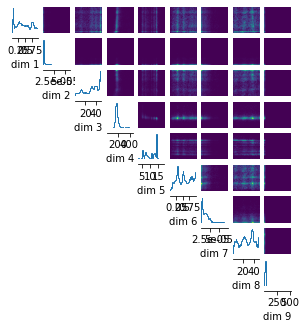

In [7]:
posterior_samples = posterior.sample((10000,),x = x_0) # 50 mins for sampling

from sbi import analysis as analysis
_ = analysis.pairplot(
    posterior_samples, figsize=(5, 5)
)

In [8]:
mdic = {"theta_new": posterior_samples.numpy(), "theta_old":theta.numpy(), "sims_old":x.numpy(),"observation":x_0.numpy()}
sio.savemat("BVCBM_SNPE_pan1_theta20k.mat", mdic)

In [9]:
initial_data = sio.loadmat("BVCBM_SNPE_pan1_sims30k.mat")
theta = torch.from_numpy(initial_data["theta_new"]).to(torch.float32)
x = torch.from_numpy(initial_data["post_pred_sim"]).to(torch.float32)

In [10]:
proposal = posterior.set_default_x(x_0)

In [11]:
density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
posterior = inference.build_posterior(density_estimator)

Using SNPE-C with atomic loss


AssertionError: NaN/Inf present in prior eval.